In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bike-sharing-demand/sampleSubmission.csv
/kaggle/input/bike-sharing-demand/train.csv
/kaggle/input/bike-sharing-demand/test.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

df_train = pd.read_csv('/kaggle/input/bike-sharing-demand/train.csv')
df_test = pd.read_csv('/kaggle/input/bike-sharing-demand/test.csv')

## Data Exploration and Visualization ##

In [3]:
df_train.isnull().sum()
df_test.isnull().sum()

# There are no missing values in train and test data set

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
dtype: int64

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


<AxesSubplot:title={'center':'Count Distribution'}, xlabel='count', ylabel='Count'>

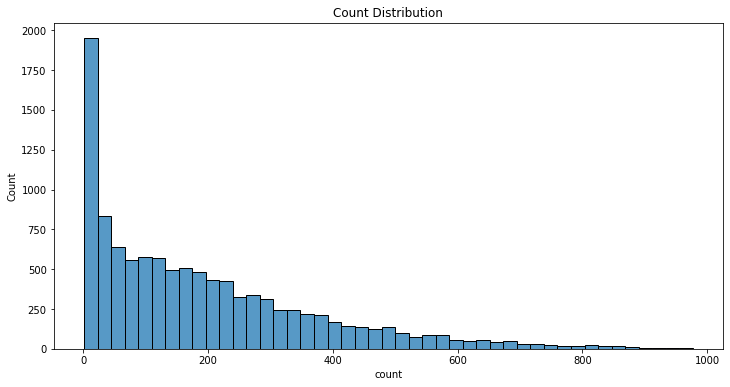

In [5]:
plt.figure(figsize=(12, 6))
plt.title('Count Distribution')
sns.histplot(data=df_train, x='count')

Text(0.5, 1.0, 'Number of rentals per season')

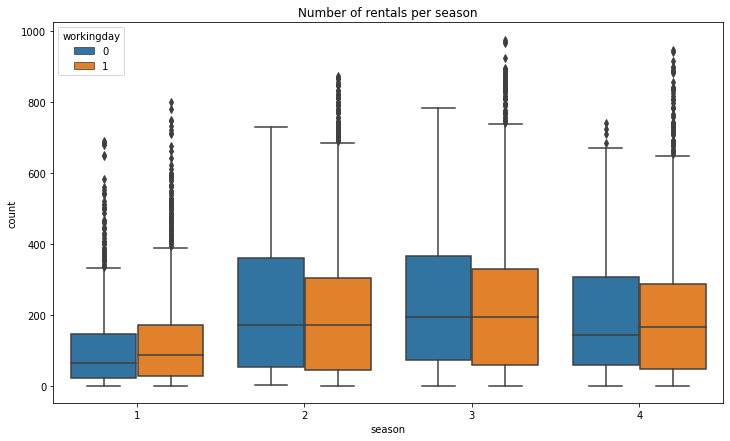

In [6]:
# Using boxplot to see the rental distribution per season
plt.figure(figsize=(12, 7))
sns.boxplot(x='season', y='count', data=df_train, hue='workingday')
plt.title('Number of rentals per season')

weather
1    205.236791
2    178.955540
3    118.846333
4    164.000000
Name: count, dtype: float64


<AxesSubplot:xlabel='weather', ylabel='count'>

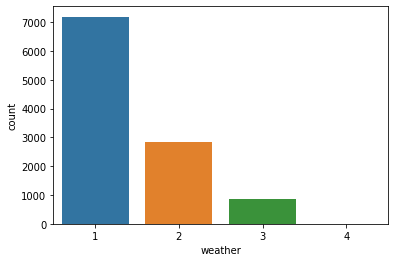

In [7]:
# Explore the count by grouping weather attribute
print(df_train.groupby('weather').mean()['count'])

# Explore the weather attribute of the data. More clear sky or rain, etc
sns.countplot(x='weather', data=df_train)

In [8]:
# Converting datetime attribute from string to datetime object
# Extract the hour, month, week of year, day of week component

def extract(df):
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['year'] = df['datetime'].apply(lambda x: x.year)
    df['hour'] = df['datetime'].apply(lambda x: x.hour)
    df['month'] = df['datetime'].apply(lambda x: x.month)
    df['woy'] = df['datetime'].apply(lambda x: x.week)
    df['dow'] = df['datetime'].apply(lambda x: x.dayofweek)

In [9]:
# Use the function for train and test sets
extract(df_train)
extract(df_test)

<AxesSubplot:xlabel='year', ylabel='count'>

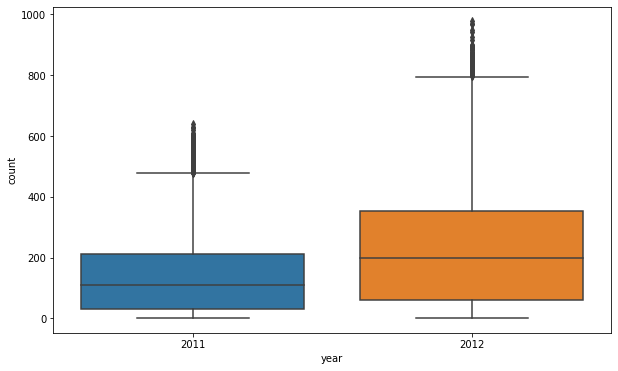

In [10]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='year', y='count', data=df_train)

<AxesSubplot:xlabel='dow', ylabel='count'>

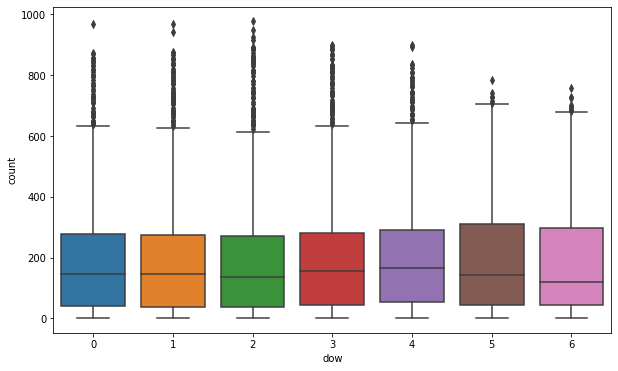

In [11]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='dow', y='count', data=df_train)

<AxesSubplot:xlabel='hour', ylabel='count'>

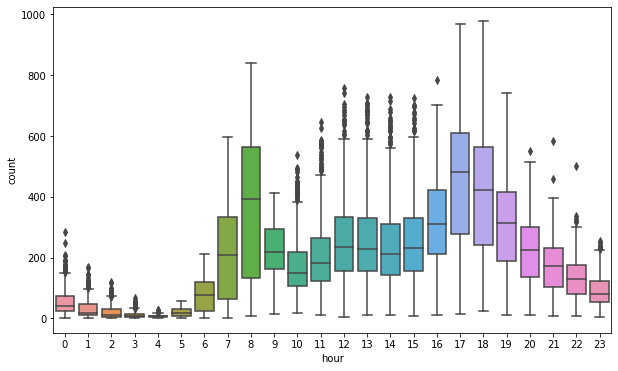

In [12]:
# Rented bikes distribution per hour
plt.figure(figsize=(10, 6))
sns.boxplot(x='hour', y='count', data=df_train)

Comment: We can see that a lot of people rent bikes around 7am-9am with the peak is at 8am. It makes sense because this is the time when people go to work or school. Once they are done for the day, the rent the bike to travel home (from 4pm to 7pm with peak at 5pm). There are some outliers between 10am-3pm. This might be due to the tourist population. A further investigation will be performed

count         1.000000
registered    0.970948
casual        0.690414
hour          0.400601
temp          0.394454
atemp         0.389784
year          0.260403
month         0.166862
season        0.163439
woy           0.152512
windspeed     0.101369
workingday    0.011594
dow          -0.002283
holiday      -0.005393
weather      -0.128655
humidity     -0.317371
Name: count, dtype: float64


<AxesSubplot:>

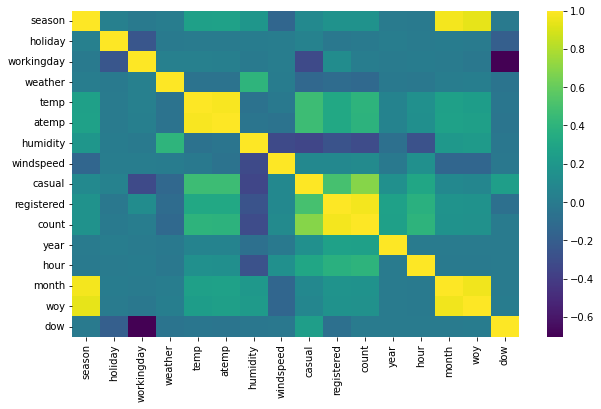

In [13]:
# Explore the correlation between each variables to count
print(df_train.corr()['count'].sort_values(ascending=False))
plt.figure(figsize=(10, 6))
sns.heatmap(df_train.corr(), cmap='viridis')

<AxesSubplot:xlabel='humidity', ylabel='count'>

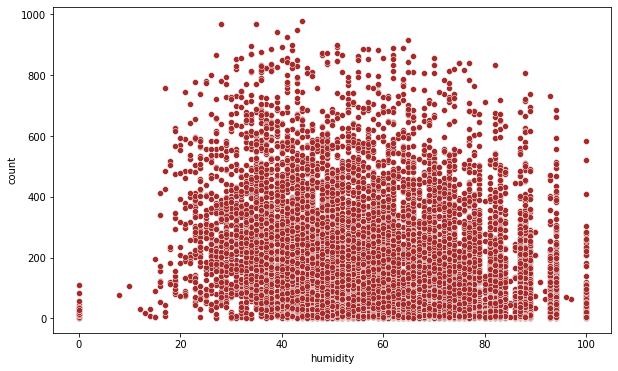

In [14]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='humidity', y='count', data=df_train, color='brown')

<AxesSubplot:xlabel='windspeed', ylabel='count'>

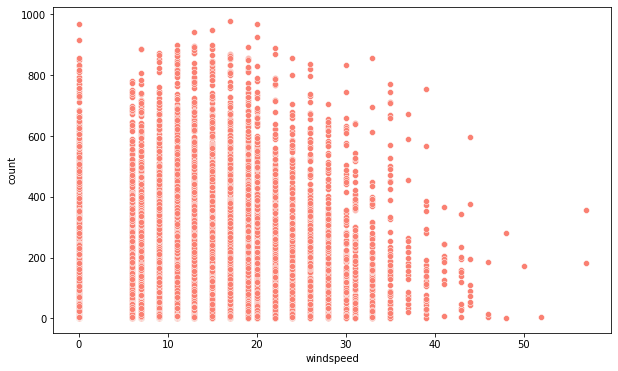

In [15]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='windspeed', y='count', data=df_train, color='salmon')

## Data Processing ##

In [16]:
# Check the number of unique entries of windspeed, temperature
list_ele = ['windspeed','temp', 'humidity']
unique_num = [x for x in df_train[list_ele].nunique()]
dict(zip(list_ele, unique_num))

{'windspeed': 28, 'temp': 49, 'humidity': 89}

In [17]:
# Since windspeed has 28 unique entries, we can try to group them into some categories, i.e (calm, light breeze, etc)
# Using the estimating wind speed table of National Weather Service
print(sorted(df_train['windspeed'].unique()))

def convert_ws(value):
    if value < 1: return 'calm'
    elif value >= 1 and value <= 3: return 'light air'
    elif value > 3 and value <= 7: return 'light breeze'
    elif value > 7 and value <= 12: return 'gentle breeze'
    elif value > 12 and value <= 18: return 'moderate breeze'
    elif value > 18 and value <= 24: return 'fresh breeze'
    elif value > 24 and value <= 31: return 'strong breeze'
    elif value > 31 and value <= 38: return 'near gale'
    elif value > 38 and value <= 46: return 'gale'
    else: return 'strong gale'

[0.0, 6.0032, 7.0015, 8.9981, 11.0014, 12.998, 15.0013, 16.9979, 19.0012, 19.9995, 22.0028, 23.9994, 26.0027, 27.9993, 30.0026, 31.0009, 32.9975, 35.0008, 36.9974, 39.0007, 40.9973, 43.0006, 43.9989, 46.0022, 47.9988, 50.0021, 51.9987, 56.9969]


In [18]:
df_train['windspeed'] = df_train['windspeed'].apply(convert_ws)
df_test['windspeed'] = df_test['windspeed'].apply(convert_ws)

<AxesSubplot:xlabel='windspeed', ylabel='count'>

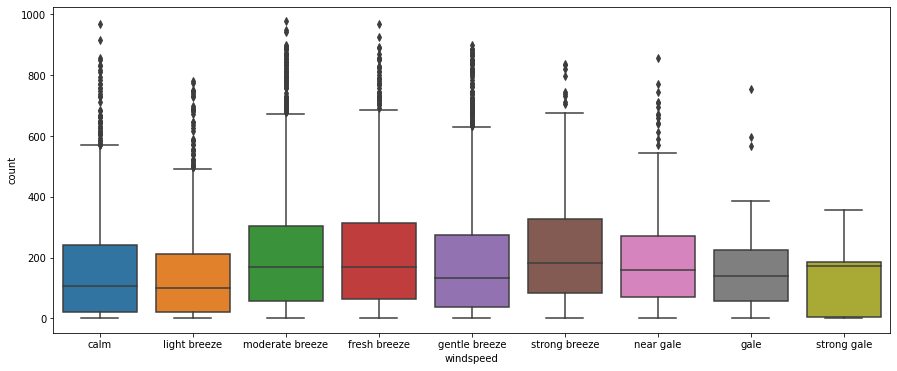

In [19]:
plt.figure(figsize=(15, 6))
sns.boxplot(x='windspeed',y='count', data=df_train)

**Comment:** It seems like that the windspeed does not affect the number of rented bikes that much. We can see that the mean of rented bikes does not change that much as the wind categories change. Considering dropping this feature.

## Drop insignificant features ##

In [20]:
# Drop the insignificance feature (datetime)
df_train.drop(['datetime','casual','registered','windspeed'], axis=1, inplace=True)
datetime_feat = df_test['datetime']
df_test.drop(['datetime','windspeed'], axis=1, inplace=True)

print(df_train.shape)
df_test.shape

(10886, 13)


(6493, 12)

## Building Prediction Model ##

**RandomForestRegressor/GridSearchCV**

In [21]:
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor

X = df_train.drop('count', axis=1)
y = df_train['count']
log_y = np.log(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=16)

my_model = RandomForestRegressor()
param_grid = {'n_estimators': [100, 140, 180, 220, 260, 300]}
modelrf_grid = GridSearchCV(my_model, param_grid=param_grid, cv=4, verbose=1, n_jobs=4)

modelrf_grid.fit(X_train, y_train)

Fitting 4 folds for each of 6 candidates, totalling 24 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 out of  24 | elapsed:   49.1s finished


GridSearchCV(cv=4, estimator=RandomForestRegressor(), n_jobs=4,
             param_grid={'n_estimators': [100, 140, 180, 220, 260, 300]},
             verbose=1)

In [22]:
modelrf_grid.best_estimator_

RandomForestRegressor(n_estimators=140)

**Evaluating The Model**

In [23]:
pred = modelrf_grid.predict(X_test)
print(f'RMSLE: {np.sqrt(mean_squared_log_error(y_test, pred)):.4f}')
print(f'R2 Score: {r2_score(y_test, pred):.4f}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, pred)):.4f}')

RMSLE: 0.3565
R2 Score: 0.9471
RMSE: 41.7011


In [24]:
sum(pred < 0)

0

*Check the error distribution*

-2.0847533779351934

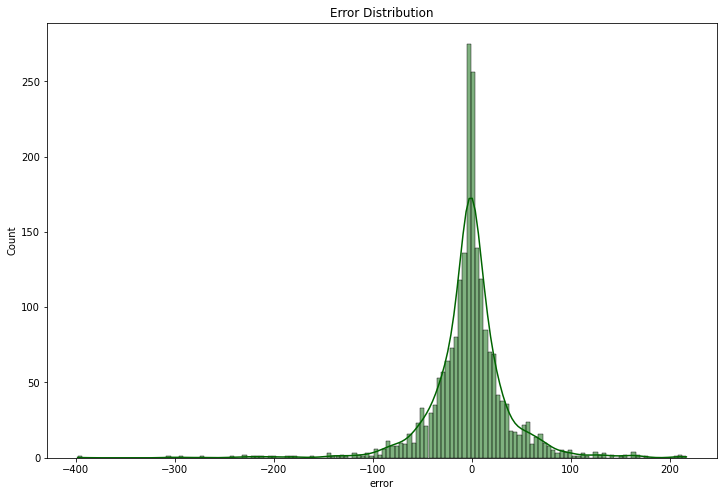

In [25]:
error = y_test-pred
plt.figure(figsize=(12, 8))
plt.title('Error Distribution')
plt.xlabel('error')
sns.histplot(error, kde=True, color='darkgreen')
np.mean(error)

Text(0.5, 1.0, 'Prediction')

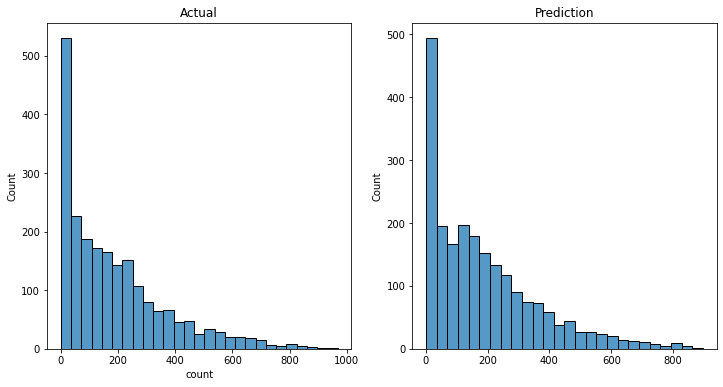

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(x=y_test, ax=ax[0])
sns.histplot(x=pred, ax=ax[1])
ax[0].set_title('Actual')
ax[1].set_title('Prediction')

In [27]:
check = pd.DataFrame({'Actual': y_test, 'Prediction':np.abs(pred)})
check

,Actual,Prediction
2728,392,404.292857
4623,334,253.207143
4773,73,87.564286
9592,25,15.785714
7881,723,752.735714
...,...,...
6480,108,95.278571
4964,106,106.335714
3797,14,17.150000
5493,9,12.485714


In [28]:
# Predict the test set
predictions = modelrf_grid.predict(df_test)

In [29]:
result = pd.DataFrame({'datetime': datetime_feat, 'count':np.abs(predictions)})
result['count'] = result['count'].apply(lambda x: round(x, 2))
result.to_csv('submission.csv', index=False)

In [30]:
result

,datetime,count
0,2011-01-20 00:00:00,12.61
1,2011-01-20 01:00:00,5.42
2,2011-01-20 02:00:00,3.46
3,2011-01-20 03:00:00,3.35
4,2011-01-20 04:00:00,3.04
...,...,...
6488,2012-12-31 19:00:00,298.97
6489,2012-12-31 20:00:00,189.18
6490,2012-12-31 21:00:00,114.91
6491,2012-12-31 22:00:00,110.21
